In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pandas_profiling import ProfileReport

from datetime import datetime
import pytz

import optuna

import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from textblob import TextBlob

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel

import sqlalchemy 
import pymysql

## Data Aquisation

In [75]:
raw_data = pd.read_csv('influencers_full.liwc.csv',on_bad_lines='skip',encoding= 'unicode_escape')

In [76]:
print(*list(raw_data.columns),sep=', ')

Account, User Name, Followers at Posting, Post Created, Post Created Date, Post Created Time, Type, Total Interactions, Likes, Comments, Views, Like and View Counts Disabled, URL, Link, Photo, Title, Description, Image Text, Sponsor Id, Sponsor Name, Total Interactions (weighted  â  Likes 1x Comments 1x ), Overperforming Score, cvfold, WC, Analytic, Clout, Authentic, Tone, WPS, Sixltr, Dic, function, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, AllPunc, Period, Comma, Colon, SemiC, QMark,

In [77]:
raw_data.shape

(299964, 116)

In [78]:
raw_data.describe()

,Followers at Posting,Total Interactions,Likes,Comments,Views,Title,Sponsor Id,Sponsor Name,Total Interactions (weighted â Likes 1x Comments 1x ),Overperforming Score,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
count,256140.000000,299964.000000,299964.000000,299964.000000,2.999640e+05,0.0,0.0,0.0,299964.000000,299958.000000,...,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000,299964.000000
mean,47426.511279,1794.848932,1750.957758,43.891174,1.671560e+03,NaN,NaN,NaN,1794.848932,1.073768,...,1.941717,0.540235,0.017856,0.572301,4.309720,0.839629,0.770971,1.968561,0.583866,18.639588
std,26763.017637,1902.321290,1868.306481,110.126791,2.525150e+04,NaN,NaN,NaN,1902.321290,5.675180,...,4.376725,3.571030,0.383952,3.795384,14.668332,6.810003,4.678809,4.584476,3.551831,26.961368
min,1002.000000,746.000000,208.000000,0.000000,0.000000e+00,NaN,NaN,NaN,746.000000,-14.150000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26974.000000,968.000000,943.000000,14.000000,0.000000e+00,NaN,NaN,NaN,968.000000,-1.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,44370.000000,1303.000000,1270.000000,26.000000,0.000000e+00,NaN,NaN,NaN,1303.000000,1.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.520000
75%,64307.500000,1998.000000,1952.000000,48.000000,0.000000e+00,NaN,NaN,NaN,1998.000000,2.100000,...,2.540000,0.000000,0.000000,0.000000,3.850000,0.000000,0.000000,2.440000,0.000000,25.000000
max,558940.000000,104703.000000,104238.000000,30761.000000,5.906940e+06,NaN,NaN,NaN,104703.000000,929.430000,...,200.000000,400.000000,50.000000,450.000000,1800.000000,1240.000000,200.000000,100.000000,200.000000,2300.000000


In [79]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299964 entries, 0 to 299963
Columns: 116 entries, Account to OtherP
dtypes: bool(1), float64(97), int64(6), object(12)
memory usage: 263.5+ MB


In [80]:
na_summary = pd.DataFrame(raw_data.isnull().sum(),columns=['na_count'])
na_summary[na_summary.na_count>0]

,na_count
Account,6
Followers at Posting,43824
URL,97
Link,97
Photo,4
Title,299964
Description,6047
Image Text,292107
Sponsor Id,299964
Sponsor Name,299964


Note that columns that encounters null values are all sitting on the instagram page side rather than the text part of the data.

### Segregate data for discovery purpose

In [159]:
instagram_data = raw_data.iloc[:,:22]
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created',
       'Post Created Date', 'Post Created Time', 'Type', 'Total Interactions',
       'Likes', 'Comments', 'Views', 'Like and View Counts Disabled', 'URL',
       'Link', 'Photo', 'Title', 'Description', 'Image Text', 'Sponsor Id',
       'Sponsor Name',
       'Total Interactions (weighted  â  Likes 1x Comments 1x )',
       'Overperforming Score'],
      dtype='object')

In [160]:
instagram_data.dtypes

Account                                                       object
User Name                                                     object
Followers at Posting                                         float64
Post Created                                                  object
Post Created Date                                             object
Post Created Time                                             object
Type                                                          object
Total Interactions                                             int64
Likes                                                          int64
Comments                                                       int64
Views                                                          int64
Like and View Counts Disabled                                   bool
URL                                                           object
Link                                                          object
Photo                             

In [161]:
cols=list(instagram_data.columns)
cols[-2] = 'Total Interactions (weighted on likes 1x Comments 1x)'
instagram_data.columns = cols

In [162]:
print(*list(instagram_data.columns), sep=', ')

Account, User Name, Followers at Posting, Post Created, Post Created Date, Post Created Time, Type, Total Interactions, Likes, Comments, Views, Like and View Counts Disabled, URL, Link, Photo, Title, Description, Image Text, Sponsor Id, Sponsor Name, Total Interactions (weighted on likes 1x Comments 1x), Overperforming Score


In [281]:
train_test_ind = raw_data.iloc[:,22]

In [282]:
text_data = raw_data.iloc[:,23:]
print(*list(text_data.columns), sep=', ')

WC, Analytic, Clout, Authentic, Tone, WPS, Sixltr, Dic, function, pronoun, ppron, i, we, you, shehe, they, ipron, article, prep, auxverb, adverb, conj, negate, verb, adj, compare, interrog, number, quant, affect, posemo, negemo, anx, anger, sad, social, family, friend, female, male, cogproc, insight, cause, discrep, tentat, certain, differ, percept, see, hear, feel, bio, body, health, sexual, ingest, drives, affiliation, achieve, power, reward, risk, focuspast, focuspresent, focusfuture, relativ, motion, space, time, work, leisure, home, money, relig, death, informal, swear, netspeak, assent, nonflu, filler, AllPunc, Period, Comma, Colon, SemiC, QMark, Exclam, Dash, Quote, Apostro, Parenth, OtherP


### Datetime Encoding

In [165]:
def convert_ts(dt_str):
    ts = dt_str[:-4]
    fmt = "%Y-%m-%d %H:%M:%S"
    read_in_dt = datetime.strptime(ts,fmt)
    local_tz = pytz.timezone('US/Eastern')
    date_local = local_tz.localize(read_in_dt)
    return date_local

In [166]:
trans_ts = lambda x: convert_ts(x)

In [167]:
instagram_data.loc[:,'Post Created'] = instagram_data['Post Created'].apply(trans_ts)

In [168]:
instagram_data['PostCreatedYear'] = pd.DatetimeIndex(instagram_data['Post Created']).year
instagram_data['PostCreatedMonth'] = pd.DatetimeIndex(instagram_data['Post Created']).month
instagram_data['PostCreatedDay'] = pd.DatetimeIndex(instagram_data['Post Created']).weekday
instagram_data['PostCreatedHour'] = pd.DatetimeIndex(instagram_data['Post Created']).hour

### Drop columns that has too many NAs or not used in this study

In [169]:
instagram_data = instagram_data.drop(['Title','Sponsor Id','Sponsor Name','Post Created Date', 'Post Created Time','URL'],axis=1)

### Transformation on Link

In [170]:
instagram_data['is_linked'] = np.where(pd.isnull(instagram_data['Link']),0,1)
instagram_data = instagram_data.drop('Link',axis=1)

In [171]:
instagram_data.isnull().sum()

Account                                                       6
User Name                                                     0
Followers at Posting                                      43824
Post Created                                                  0
Type                                                          0
Total Interactions                                            0
Likes                                                         0
Comments                                                      0
Views                                                         0
Like and View Counts Disabled                                 0
Photo                                                         4
Description                                                6047
Image Text                                               292107
Total Interactions (weighted on likes 1x Comments 1x)         0
Overperforming Score                                          6
PostCreatedYear                         

## Data Discovery: Instagram page descriptive analysis

### Fill NA: Account

In [172]:
instagram_data[instagram_data.Account.isnull()]['User Name']

61463     justluxeee
98412     justluxeee
115530    justluxeee
138319    justluxeee
176068    justluxeee
232734    justluxeee
Name: User Name, dtype: object

In [173]:
instagram_data[instagram_data['User Name'] == 'justluxeee']

,Account,User Name,Followers at Posting,Post Created,Type,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Photo,Description,Image Text,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked
61463,NaN,justluxeee,NaN,2020-10-08 14:42:36-04:00,Photo,2227,2198,29,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Iâm heating up ð¸@2020photography3 ð @i...,NaN,2227,1.91,2020,10,3,14,1
98412,NaN,justluxeee,NaN,2021-06-24 22:07:21-04:00,Album,1707,1647,60,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Miss Mamasð,NaN,1707,1.42,2021,6,3,22,1
115530,NaN,justluxeee,NaN,2020-11-02 16:54:32-05:00,Photo,1546,1545,1,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Not one of them,NaN,1546,1.33,2020,11,0,16,1
138319,NaN,justluxeee,NaN,2020-02-19 15:13:41-05:00,Photo,1375,1372,3,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Itâs Luxzurious to youð\nð· @capturedby...,NaN,1375,1.18,2020,2,2,15,1
176068,NaN,justluxeee,NaN,2021-06-02 13:42:25-04:00,Album,1164,1140,24,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,"i ain got no free time, everythingâs expensive",NaN,1164,-1.03,2021,6,2,13,1
232734,NaN,justluxeee,NaN,2020-09-17 12:17:35-04:00,Photo,941,917,24,0,False,https://scontent-sea1-1.cdninstagram.com/v/t51...,Checking in,NaN,941,-1.24,2020,9,3,12,1


We failed to fetch any information of this NA account based on user name. We will drop these records.

In [174]:
instagram_data = instagram_data[~instagram_data.Account.isnull()]
instagram_data.shape

(299958, 20)

### Target Variable: Followers at Posting
Randomly pick accounts and look at follower growth.

- accumulated number of posts within time period
- variance of followers
- detection of jumps (isolation forest)
- seasonality underlying
- platform performance (external research)

In [97]:
choices = np.random.choice(np.unique(instagram_data.Account), 10, replace=False)
random10 = instagram_data[instagram_data.Account.isin(choices)]

Account
Ali landry                     AxesSubplot(0.125,0.2;0.775x0.68)
Chelsea Spack                  AxesSubplot(0.125,0.2;0.775x0.68)
Eamon                          AxesSubplot(0.125,0.2;0.775x0.68)
MAQUILLAJE, PEINADO Y CEJAS    AxesSubplot(0.125,0.2;0.775x0.68)
Ryan Van Duzer                 AxesSubplot(0.125,0.2;0.775x0.68)
S A N D I   T H O M            AxesSubplot(0.125,0.2;0.775x0.68)
TIM BARRY                      AxesSubplot(0.125,0.2;0.775x0.68)
Thomas Jack                    AxesSubplot(0.125,0.2;0.775x0.68)
Travel Curator                 AxesSubplot(0.125,0.2;0.775x0.68)
adelia rasya                   AxesSubplot(0.125,0.2;0.775x0.68)
Name: Followers at Posting, dtype: object

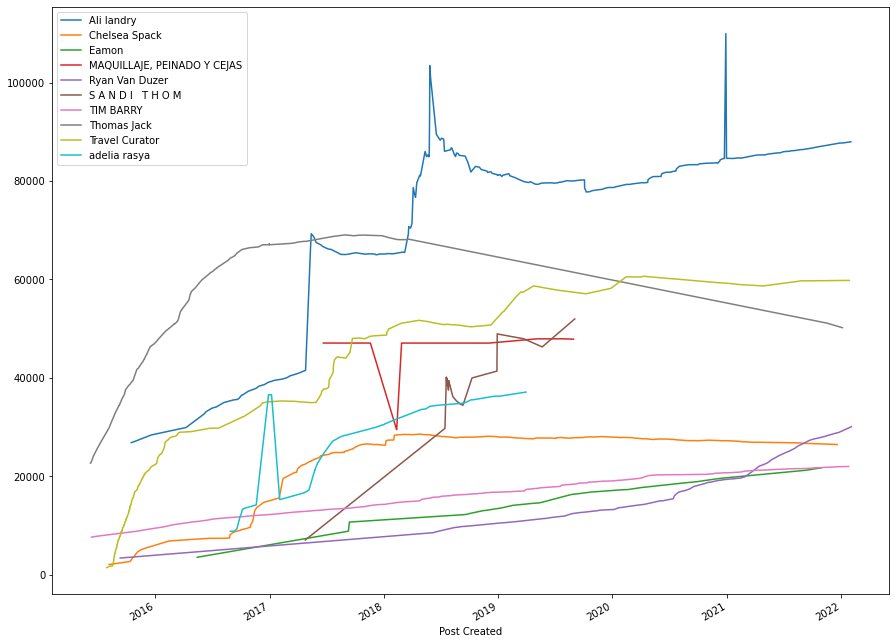

In [98]:
%matplotlib inline
random10_data = random10.loc[:,['Followers at Posting','Account','Post Created']]
random10_data['Post Created'] = pd.to_datetime(random10_data['Post Created'])
random10_data = random10_data.set_index('Post Created')
fig, ax = plt.subplots(figsize=(15,12))
random10_data.groupby('Account')['Followers at Posting'].plot(legend=True,ax=ax)

#### Focus on accounts encounter null

In [99]:
account_encounter_null = np.unique(random10[random10['Followers at Posting'].isnull()]['Account'])
account_encounter_null

array(['Ali landry', 'Chelsea Spack', 'MAQUILLAJE, PEINADO Y CEJAS',
       'TIM BARRY', 'Thomas Jack'], dtype=object)

Account
Ali landry                     AxesSubplot(0.125,0.2;0.775x0.68)
Chelsea Spack                  AxesSubplot(0.125,0.2;0.775x0.68)
MAQUILLAJE, PEINADO Y CEJAS    AxesSubplot(0.125,0.2;0.775x0.68)
TIM BARRY                      AxesSubplot(0.125,0.2;0.775x0.68)
Thomas Jack                    AxesSubplot(0.125,0.2;0.775x0.68)
Name: Followers at Posting, dtype: object

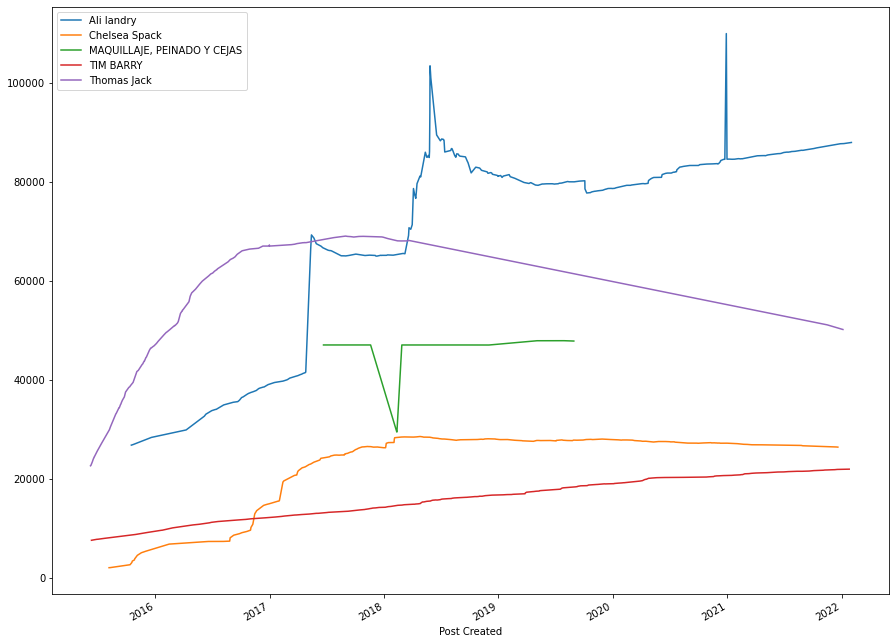

In [100]:
%matplotlib inline
random10_data = random10.loc[random10.Account.isin(account_encounter_null),['Followers at Posting','Account','Post Created']]
random10_data['Post Created'] = pd.to_datetime(random10_data['Post Created'])
random10_data = random10_data.set_index('Post Created')
fig, ax = plt.subplots(figsize=(15,12))
random10_data.groupby('Account')['Followers at Posting'].plot(legend=True,ax=ax)

Consider followers is our target variable, we should consider simply drop records encountering NA values.

In [175]:
instagram_data = instagram_data[~instagram_data['Followers at Posting'].isnull()]

In [176]:
instagram_data.shape

(256140, 20)

In [177]:
instagram_data.isnull().sum()

Account                                                       0
User Name                                                     0
Followers at Posting                                          0
Post Created                                                  0
Type                                                          0
Total Interactions                                            0
Likes                                                         0
Comments                                                      0
Views                                                         0
Like and View Counts Disabled                                 0
Photo                                                         4
Description                                                4513
Image Text                                               248577
Total Interactions (weighted on likes 1x Comments 1x)         0
Overperforming Score                                          0
PostCreatedYear                         

### Handle Text Variable

Photo is a photo link url. 

In [178]:
instagram_data[instagram_data.Photo.isnull()]

,Account,User Name,Followers at Posting,Post Created,Type,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Photo,Description,Image Text,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked
24445,Aj Ramos,theajramos,35619.0,2017-09-25 03:26:30-04:00,Album,3495,3413,82,10209,False,NaN,It was around this time I told last year (2:50...,NaN,3495,2.05,2017,9,0,3,1
57899,veÌriteÌ,verite,48463.0,2021-04-20 14:50:02-04:00,Photo,2299,2229,70,0,False,NaN,my essence captured in one photo.\ni am a brok...,NaN,2299,1.22,2021,4,1,14,1
249923,slothrust,slothrust,24418.0,2021-07-23 14:34:34-04:00,Album,886,866,20,4152,False,NaN,VERY pleased to have our unreleased song âA ...,NaN,886,-1.57,2021,7,4,14,1
282454,Nathan Foley,nathanfoleyofficial,13781.0,2019-08-28 03:02:45-04:00,Album,795,740,55,4910,False,NaN,Our Highlighted Wedding Video â¤ï¸ SWIPE LEF...,NaN,795,2.56,2019,8,2,3,1


Due to the characteristics of Instagram, a post has to come with a image/vedio. In this case, we assume the image link is lost, all of the posts has 'Photo' available. We simply drop this column as it's not related to our study.

In [179]:
instagram_data = instagram_data.drop('Photo',axis=1)

### Assign Sentiment Score and Attach Descriptive Info to Text columns.
We have two of these columns to transform: Description and Image Text

#### Clean Text: Remove stopwords, tokenized and lemmatization

In [180]:
instagram_data['Description'] = instagram_data['Description'].str.strip()

In [248]:
def remove_unprintable_char(s):
    new_s = re.sub(r'[^a-zA-Z0-9\._-]', ' ', s)
    return new_s

In [249]:
instagram_data['Description'] = instagram_data['Description'].apply(str).map(remove_unprintable_char)

In [250]:
def process_description(text):
    if not pd.isnull(text):
        # tokenize 
        tags = nltk.pos_tag(word_tokenize(text))
        #Import the english stop words list from NLTK
        stopwords_english = stopwords.words('english') 

        #Creating a list of words without stopwords
        pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
        desc_clean = []
        for word, tag in tags:
            if word not in stopwords_english and word not in string.punctuation:
                desc_clean.append(tuple([word.lower(), pos_dict.get(tag[0])]))

        #Instantiate stemming class
        lemmatizer = WordNetLemmatizer()

        #Creating a list of stems of words 
        lemma_desc = ""
        for clean_word, pos in desc_clean:
            if not pos:
                lemma = clean_word
                lemma_desc = lemma_desc + " " + lemma
            else:
                lemma = lemmatizer.lemmatize(clean_word, pos=pos)
                lemma_desc = lemma_desc + " " + lemma
    else:
        lemma_desc = ''
    return lemma_desc

In [261]:
instagram_data['Description_lemma'] = instagram_data['Description'].apply(process_description)

#### Sentiment and subjective score

In [262]:
def datablob(lemma):
    return TextBlob(lemma).sentiment

In [263]:
instagram_data['Description_senti'] = instagram_data['Description_lemma'].apply(datablob)

In [264]:
instagram_data['Description_sentiment'] = np.where(instagram_data['Description_senti'].str[0]>0,'Positive','Negative')
instagram_data['Description_subjective'] = np.where(instagram_data['Description_senti'].str[1]>0.5,'Subjective','Objective')

In [265]:
instagram_data['Description_sentiment_score'] = instagram_data['Description_senti'].str[0]
instagram_data['Description_subjective_score'] = instagram_data['Description_senti'].str[1]

#### Descriptive info
Potentially we can look into how many characteristics/capital letters were used

In [266]:
instagram_data['Description_len'] =  instagram_data['Description'].str.len().fillna(0)

In [267]:
instagram_data = instagram_data.drop(['Description_lemma','Description_senti'],axis=1)

In [268]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective', 'Description_len',
       'Image_Text_len', 'account_effect', 'Type_cate',
       'Description_sentiment_score', 'Description_subjective_score'],
      dtype='object')

### Understand and process Image Text

In [209]:
instagram_data[~instagram_data['Image Text'].isnull()]['Image Text']

31                                    JUNE PART PARTTWO TWO
89              REBECCA FERGUSON LADY JESSICA TUNE ITBEGINS
112                     KATHLEEN WILLEY WHITE HOUSE STAFF W
116       TIMOTHÃE REBECCA OSCAR STELLAN STEPHEN CHANG ...
167       Governor Jay Inslee @GovInslee I cannot expres...
                                ...                        
299436                                    BLACKWIDOW KILLER
299548                                     à´¤ LackTraviata
299643    Announcing our 2021 festival line-up! MAGICCIT...
299647    ** JANUARY 13 2015 RYMAN AUDITORIUM ASHVILLE*T...
299949    MY 2019 GREAT NORDEEN XC RACE RECAP 30K & 90 M...
Name: Image Text, Length: 7563, dtype: object

Image Text has different forms, some of them have comments, some of them act more like a image title. In this case we extract only descriptive information from this attribute.

In [210]:
instagram_data['Image Text'] = instagram_data['Image Text'].str.strip()
instagram_data['Image_Text_len'] = instagram_data['Image Text'].str.len().fillna(0)

In [212]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective', 'Description_len',
       'Image_Text_len'],
      dtype='object')

### Encoding Account
Potentially could be transformed via entity embedding using fastai. For time and complexity consideration we will stick with traditional target encoding.

In [213]:
len(np.unique(instagram_data['Account']))

1271

In [214]:
len(np.unique(instagram_data['User Name']))

1272

Account and User Name is roughly 1-1.

In [230]:
account_effect_lookup = instagram_data.groupby('Account')['Followers at Posting'].mean().reset_index().rename(columns={"Followers at Posting":"account_effect"})

In [231]:
account_effect_lookup

,Account,account_effect
0,#payphoneography,71660.024390
1,/ johan,27914.571429
2,A Great Big World,53350.181818
3,A L E X A N D E R W R A I T H,55983.400000
4,A L I Y A H â¥ï¸ O â B R I E N,10738.147059
...,...,...
1266,ðð¦Meganð¦ð,16452.450000
1267,ð· Adeline Gressin âï¸,12218.400000
1268,ð¥Kenjon Barnerð¥,69078.000000
1269,ð· MISS BETTY ROSEð·,44182.613718


In [234]:
instagram_data = instagram_data.merge(account_effect_lookup, on = 'Account', how='left')

Note the unprintable characters also exists in Account column.

In [269]:
instagram_data['Account'] = instagram_data['Account'].apply(remove_unprintable_char)

### Encode Type

In [237]:
np.unique(instagram_data['Type'])

array(['Album', 'Photo', 'Video'], dtype=object)

In [239]:
instagram_data['Type_cate'] = instagram_data.loc[:,'Type'].astype("category").cat.codes

In [241]:
instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective', 'Description_len',
       'Image_Text_len', 'account_effect', 'Type_cate'],
      dtype='object')

### Data check point

In [283]:
select_train_test_ind = train_test_ind[instagram_data.index]

In [284]:
select_text_data = text_data.loc[instagram_data.index,:]

In [285]:
transformed_instagram_data = instagram_data.join(select_train_test_ind)

In [286]:
transformed_instagram_data.columns

Index(['Account', 'User Name', 'Followers at Posting', 'Post Created', 'Type',
       'Total Interactions', 'Likes', 'Comments', 'Views',
       'Like and View Counts Disabled', 'Description', 'Image Text',
       'Total Interactions (weighted on likes 1x Comments 1x)',
       'Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'PostCreatedDay', 'PostCreatedHour', 'is_linked',
       'Description_sentiment', 'Description_subjective', 'Description_len',
       'Image_Text_len', 'account_effect', 'Type_cate',
       'Description_sentiment_score', 'Description_subjective_score',
       'cvfold'],
      dtype='object')

In [293]:
transformed_instagram_data.to_csv('ins_account_data.csv')
select_text_data.to_csv('ins_text_data.csv')

### Write to SQL

In [2]:
user = "admin"
password = "tuIzaqrAKLMe32G0"
host = "instagram-data-db.csik1hfjt1qb.us-east-1.rds.amazonaws.com"
port = 3306
db = "instagram_data"
connection_engine = sqlalchemy.create_engine('mysql+pymysql://' + user + ':' + password + '@' + host + ':' + str(port) + '/' + db , echo=True)

In [296]:
transformed_instagram_data.to_sql(con=connection_engine, name='ins_account_data', if_exists='replace', index=True)

2022-04-04 08:51:07,081 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 08:51:07,082 INFO sqlalchemy.engine.Engine [cached since 475.3s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data'}
2022-04-04 08:51:07,273 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 08:51:07,273 INFO sqlalchemy.engine.Engine [cached since 475.5s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_account_data'}
2022-04-04 08:51:07,463 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `instagram_data`
2022-04-04 08:51:07,464 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-04 08:51:07,540 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `ins_account_data`
2022-04-04 08:51:07,541 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-04 08:51:07,672 INFO sqlalchemy.en

In [297]:
select_text_data.to_sql(con=connection_engine, name='ins_text_data', if_exists='replace', index=True)

2022-04-04 08:51:55,834 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 08:51:55,835 INFO sqlalchemy.engine.Engine [cached since 524s ago] {'table_schema': 'instagram_data', 'table_name': 'ins_text_data'}
2022-04-04 08:51:55,986 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-04-04 08:51:55,992 INFO sqlalchemy.engine.Engine 
CREATE TABLE ins_text_data (
	`index` BIGINT, 
	`WC` BIGINT, 
	`Analytic` FLOAT(53), 
	`Clout` FLOAT(53), 
	`Authentic` FLOAT(53), 
	`Tone` FLOAT(53), 
	`WPS` FLOAT(53), 
	`Sixltr` FLOAT(53), 
	`Dic` FLOAT(53), 
	`function` FLOAT(53), 
	pronoun FLOAT(53), 
	ppron FLOAT(53), 
	i FLOAT(53), 
	we FLOAT(53), 
	you FLOAT(53), 
	shehe FLOAT(53), 
	they FLOAT(53), 
	ipron FLOAT(53), 
	article FLOAT(53), 
	prep FLOAT(53), 
	auxverb FLOAT(53), 
	adverb FLOAT(53), 
	conj FLOAT(53), 
	negate FLOAT(53), 
	verb FLOAT(53), 
	adj FLOAT(53), 
	compare FLOAT(53), 
	inte

In [298]:
pd.read_sql("show tables", con = connection_engine)

2022-04-04 08:54:43,213 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 08:54:43,214 INFO sqlalchemy.engine.Engine [cached since 691.4s ago] {'table_schema': 'instagram_data', 'table_name': 'show tables'}
2022-04-04 08:54:43,355 INFO sqlalchemy.engine.Engine show tables
2022-04-04 08:54:43,356 INFO sqlalchemy.engine.Engine [raw sql] {}


,Tables_in_instagram_data
0,ins_account_data
1,ins_text_data


### Pandas Profiling on account information

In [3]:
transformed_instagram_data = pd.read_sql('select * from ins_account_data',con=connection_engine)

2022-04-04 14:31:36,824 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2022-04-04 14:31:36,825 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-04 14:31:36,955 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2022-04-04 14:31:36,956 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-04 14:31:37,020 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2022-04-04 14:31:37,021 INFO sqlalchemy.engine.Engine [raw sql] {}
2022-04-04 14:31:37,211 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 14:31:37,212 INFO sqlalchemy.engine.Engine [generated in 0.00107s] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_account_data'}
2022-04-04 14:31:37,358 INFO sqlalchemy.engine.Engine select * from ins_account_data
2022-04-04 14:31:37,359 INFO sqlalchemy.engine.Engine [raw sql] {}


In [5]:
profile = ProfileReport(transformed_instagram_data, title="Pandas Profiling Report", correlations=None, interactions={'continuous': False}, explorative=False)
profile.to_file(output_file="data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

We noticed 'Like and View Counts Disabled' is unary after we remove problematic rows.

### Correlation matrix

In [6]:
corr = transformed_instagram_data.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,df_index,Followers at Posting,Total Interactions,Likes,Comments,Views,Like and View Counts Disabled,Total Interactions (weighted on likes 1x Comments 1x),Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,is_linked,Description_len,Image_Text_len,account_effect,Type_cate,Description_sentiment_score,Description_subjective_score
df_index,1.000000,-0.272367,-0.556552,-0.553438,-0.221729,-0.044155,nan,-0.556552,-0.218247,-0.138588,-0.007571,0.003940,-0.006014,-0.014575,-0.016066,-0.006560,-0.194523,0.059954,0.002213,-0.000421
Followers at Posting,-0.272367,1.000000,0.372014,0.376238,0.041858,0.015605,nan,0.372014,0.014562,0.160178,0.008511,-0.003711,-0.011286,-0.002537,0.021181,0.015452,0.852383,-0.013796,0.001390,0.001226
Total Interactions,-0.556552,0.372014,1.000000,0.998433,0.330469,0.086273,nan,1.000000,0.267380,0.130513,0.012320,-0.006665,0.004576,0.007259,0.004940,0.007607,0.304983,-0.054821,-0.006757,-0.007025
Likes,-0.553438,0.376238,0.998433,1.000000,0.277134,0.084281,nan,0.998433,0.255629,0.125974,0.012783,-0.005634,0.003794,0.007034,0.001206,0.005422,0.309812,-0.056701,-0.007076,-0.008413
Comments,-0.221729,0.041858,0.330469,0.277134,1.000000,0.059832,nan,0.330469,0.279484,0.116238,-0.004069,-0.019409,0.014581,0.005991,0.064482,0.039153,0.011282,0.015042,0.003328,0.021258
Views,-0.044155,0.015605,0.086273,0.084281,0.059832,1.000000,nan,0.086273,0.152370,0.025332,-0.003101,0.001332,0.002325,0.001158,-0.001065,-0.004218,0.009728,0.115375,-0.005170,-0.000515
Like and View Counts Disabled,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Total Interactions (weighted on likes 1x Comments 1x),-0.556552,0.372014,1.000000,0.998433,0.330469,0.086273,nan,1.000000,0.267380,0.130513,0.012320,-0.006665,0.004576,0.007259,0.004940,0.007607,0.304983,-0.054821,-0.006757,-0.007025
Overperforming Score,-0.218247,0.014562,0.267380,0.255629,0.279484,0.152370,nan,0.267380,1.000000,0.065969,-0.001982,-0.002549,0.004428,0.008685,0.051400,0.012027,-0.051470,0.077646,0.006280,0.016041
PostCreatedYear,-0.138588,0.160178,0.130513,0.125974,0.116238,0.025332,nan,0.130513,0.065969,1.000000,-0.127280,-0.015727,0.011204,0.010482,0.146914,0.121830,-0.143789,-0.143665,0.020541,0.050835


With this matrix we can throw away highly correlated variables.

In [15]:
ins_account_input = transformed_instagram_data.drop(['Account','User Name','Post Created','Type',
                                                     'Total Interactions (weighted on likes 1x Comments 1x)',
                                                     'Description', 'Image Text','Description_sentiment',
                                                     'Description_subjective','Like and View Counts Disabled'],axis=1)

In [16]:
ins_account_input = ins_account_input.set_index('df_index')

In [28]:
ins_account_input.shape

(256140, 18)

## Preprocessing before modeling

In [21]:
text_data = pd.read_sql('select * from ins_text_data',con=connection_engine)
text_data = text_data.set_index('index')

2022-04-04 15:29:29,414 INFO sqlalchemy.engine.Engine SELECT COUNT(*) FROM information_schema.tables WHERE table_schema = %(table_schema)s AND table_name = %(table_name)s
2022-04-04 15:29:29,415 INFO sqlalchemy.engine.Engine [cached since 3472s ago] {'table_schema': 'instagram_data', 'table_name': 'select * from ins_text_data'}
2022-04-04 15:29:29,542 INFO sqlalchemy.engine.Engine select * from ins_text_data
2022-04-04 15:29:29,543 INFO sqlalchemy.engine.Engine [raw sql] {}


In [22]:
complete_data = ins_account_input.join(text_data)

In [27]:
complete_data.shape

(256140, 111)

### Label Encoding for encoded datetime

In [31]:
complete_data['PostCreatedYear'] = complete_data['PostCreatedYear'].astype("category").cat.codes
complete_data['PostCreatedMonth'] = complete_data['PostCreatedMonth'].astype("category").cat.codes
complete_data['PostCreatedDay'] = complete_data['PostCreatedDay'].astype("category").cat.codes
complete_data['PostCreatedHour'] = complete_data['PostCreatedHour'].astype("category").cat.codes

### Train Test split

In [32]:
np.unique(complete_data['cvfold'])

array(['test', 'train'], dtype=object)

In [33]:
train_set = complete_data[complete_data.cvfold=='train']
test_set = complete_data[complete_data.cvfold=='test']

In [34]:
train_set

,Followers at Posting,Total Interactions,Likes,Comments,Views,Overperforming Score,PostCreatedYear,PostCreatedMonth,PostCreatedDay,PostCreatedHour,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
df_index,,,,,,,,,,,,,,,,,,,,,
0,404268.0,104703,104238,465,0,3.29,7,9,6,13,...,0.00,0.0,0.0,0.0,16.67,0.00,0.00,8.33,16.67,16.67
1,490753.0,102836,102426,410,0,2.74,7,10,0,11,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,33.33
2,472941.0,101672,101230,442,0,3.85,7,10,3,17,...,3.85,0.0,0.0,0.0,3.85,0.00,0.00,7.69,0.00,3.85
3,333044.0,99049,97849,1200,0,4.53,7,7,4,16,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,66.67
4,533227.0,98218,97230,988,0,2.40,7,11,4,15,...,0.00,0.0,0.0,0.0,4.55,0.00,0.00,4.55,0.00,9.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256135,29898.0,747,738,9,0,1.39,5,7,6,1,...,7.95,0.0,0.0,0.0,2.27,2.27,1.14,0.00,0.00,22.73
256136,39603.0,747,729,18,0,-1.22,3,7,4,18,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,75.00
256137,12670.0,747,731,16,0,1.36,5,2,3,10,...,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,52.94


In [41]:
X_train = train_set.drop(['Followers at Posting','cvfold'],axis=1)
y_train = train_set['Followers at Posting']
X_test = test_set.drop(['Followers at Posting','cvfold'],axis=1)
y_test = test_set['Followers at Posting']

### Feature seletion with Random Forest

In [42]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 500))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(n_estimators=500))

In [47]:
X_train.shape

(196891, 109)

In [45]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

4

In [46]:
selected_feat

Index(['Overperforming Score', 'PostCreatedYear', 'PostCreatedMonth',
       'account_effect'],
      dtype='object')

### Anormaly Detection

### Transformation

### Baseline model: Linear Regression

In [ ]:
X_train_lm = X_train_linear_base[selected_feat]
X_train_lm_cons = sm.add_constant(X_train_lm)
X_test_lm = X_test_linear_base[selected_feat]
base_linear = sm.OLS(y_train_linear_base, X_train_lm_cons)
base_linear_fitted = base_linear.fit()
print(base_linear_fitted.summary())